# Local GP - Cascading Tanks

The purpose of this notebook is to get the integration methodology working for the multiple GP method in order to appropriately calculate the tank dynamics.  For this, we'll be using the same methodology used in `1_Standard_BSS_ANOVA` with some slight modifications to account for the fact that this uses an actual GP from the `sklearn` library.

In [10]:
# Import Relevant Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern
from sklearn.model_selection import train_test_split
import plotly.express as px
import plotly.graph_objs as go
# Integration
import scipy
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d

# Load in data
tank1 = pd.read_csv('CascadedTanksFiles/tank1.csv')
tank1

,u,h1,h2,time,h1_der,h2_der
0,0.859640,0.380859,0.205078,0,0.000977,0.074219
1,0.859640,0.385742,0.576172,5,0.002441,0.051270
2,0.859640,0.405273,0.717773,10,0.006836,0.027344
3,0.859640,0.454102,0.849609,15,0.011230,0.025879
4,0.859640,0.517578,0.976562,20,0.012695,0.022949
...,...,...,...,...,...,...
2495,0.640136,1.933594,1.987305,12475,-0.003418,-0.001953
2496,0.640136,1.914062,1.977539,12480,-0.003418,-0.000977
2497,0.640136,1.899414,1.977539,12485,-0.002930,-0.000488
2498,0.640136,1.884766,1.972656,12490,-0.002930,-0.000977


## Process Derivation
This derivation is broken into three parts to model the derivatives, similar to `3_Local_GPs_Derivation.ipynb`.:
1. Create data and use k-means clustering to break data into different sets.
2. Train each set to be a GP
3. Make a prediction of the combined GPs

### Part 1: Data Processing
The first part of this creates the data from our sample function.  The input space (i and j in the equation or x1 and x2 in the dataframe) are the input space which is to be discretized by the k-means clustering.  The final visualization produced by the code shows the two sections of the data and indicates how it was bifurcated for this example with two clusters.

In [11]:
# Set random seed for reproducibility
np.random.seed(42)

num_of_clusters = 3

tank1_first_partial = tank1.copy()
tank1_first_partial = tank1_first_partial.iloc[0:2000]

# Apply k-means clustering using only x1 and x2
X = tank1_first_partial[['u', 'h1', 'h2']]
kmeans = KMeans(n_clusters=num_of_clusters, random_state=42)
tank1_first_partial['cluster'] = kmeans.fit_predict(X)

# Get cluster centroids
centroids = kmeans.cluster_centers_

# Separate data into clustered dataframes
clusters = [tank1_first_partial[tank1_first_partial['cluster'] == i] for i in range(num_of_clusters)]

# Part 2: Train the GPs

Since we have the data split into two different groups, training the GPs isn't particularly hard.  Using the enumerate function, we are able to take the data that was assigned to each cluster and use only that to train our GPs.  Fro this, we will be using a RBF based Kernel. To see what the two GP's predictions look like, I created another visualization of them.

Note that I tried the RBF Kernel and it created this choppy prediction of the derivatives where it would go to zero a lot of the time. Because of this poor prediction, I decided to use the Matern kernel.

In [12]:
# Function to create and train a Gaussian Process model
def train_gp(X, y):
    kernel = Matern(nu = 0.5) # + RBF()
    gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, random_state=42)
    gp.fit(X.values, y.values)
    return gp

# Setup to Train Gaussian Process models for each cluster
gp_models_dh1 = []
mse_scores_dh1 = []

# Train the GP clusters for dh1
for i, cluster in enumerate(clusters):
    print(f"\nTraining Gaussian Process for Cluster {i+1}")
    
    X = cluster[['u', 'h1', 'h2']]
    y = cluster['h1_der']
    
    # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    gp = train_gp(X, y)
    gp_models_dh1.append(gp)
    
    y_pred = gp.predict(X)
    
    mse = np.mean((y - y_pred)**2)
    mse_scores_dh1.append(mse)
    
    print(f"Mean Squared Error for Cluster {i+1}: {mse:.4f}")

# Setup to Train Gaussian Process models for each cluster
gp_models_dh2 = []
mse_scores_dh2 = []

# Train the GP clusters for dh2
for i, cluster in enumerate(clusters):
    print(f"\nTraining Gaussian Process for Cluster {i+1}")
    
    X = cluster[['u', 'h1', 'h2']]
    y = cluster['h2_der']
    
    # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    gp = train_gp(X, y)
    gp_models_dh2.append(gp)
    
    y_pred = gp.predict(X)
    
    mse = np.mean((y - y_pred)**2)
    mse_scores_dh2.append(mse)
    
    print(f"Mean Squared Error for Cluster {i+1}: {mse:.4f}")


Training Gaussian Process for Cluster 1


c:\Users\Michael\anaconda3\envs\online_update_controls\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\Michael\anaconda3\envs\online_update_controls\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but GaussianProcessRegressor was fitted without feature names
  warnings.warn(


Mean Squared Error for Cluster 1: 0.0000

Training Gaussian Process for Cluster 2


c:\Users\Michael\anaconda3\envs\online_update_controls\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but GaussianProcessRegressor was fitted without feature names
  warnings.warn(


Mean Squared Error for Cluster 2: 0.0000

Training Gaussian Process for Cluster 3


c:\Users\Michael\anaconda3\envs\online_update_controls\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but GaussianProcessRegressor was fitted without feature names
  warnings.warn(


Mean Squared Error for Cluster 3: 0.0000

Training Gaussian Process for Cluster 1


c:\Users\Michael\anaconda3\envs\online_update_controls\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but GaussianProcessRegressor was fitted without feature names
  warnings.warn(


Mean Squared Error for Cluster 1: 0.0000

Training Gaussian Process for Cluster 2


c:\Users\Michael\anaconda3\envs\online_update_controls\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but GaussianProcessRegressor was fitted without feature names
  warnings.warn(


Mean Squared Error for Cluster 2: 0.0000

Training Gaussian Process for Cluster 3


c:\Users\Michael\anaconda3\envs\online_update_controls\Lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Mean Squared Error for Cluster 3: 0.0000


c:\Users\Michael\anaconda3\envs\online_update_controls\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but GaussianProcessRegressor was fitted without feature names
  warnings.warn(


While somewhat hard to see from the visualization, this does match what I would expect to happen. At x1 = 0, y1 = 1, GP1 accurately predicts the function, but GP2 is off.  However at x1 = 1 and x2 = 1, GP2 accurately predicts the function and GP1 is off.  By leveraging both of these functions based on the weighted averages from the distances from the centroids, we should be able to gain a more accurate prediction of the entire function.

# Part 3: Making Derivative Predictions

For the last part of this derivation, we will be making predictions.  For this, we will implement a weighted sum based on the inverse of the Euclidean distance of a particular point to the centroids of each GP's training data.  We can then make the calculations and see how accurate the predictions are.

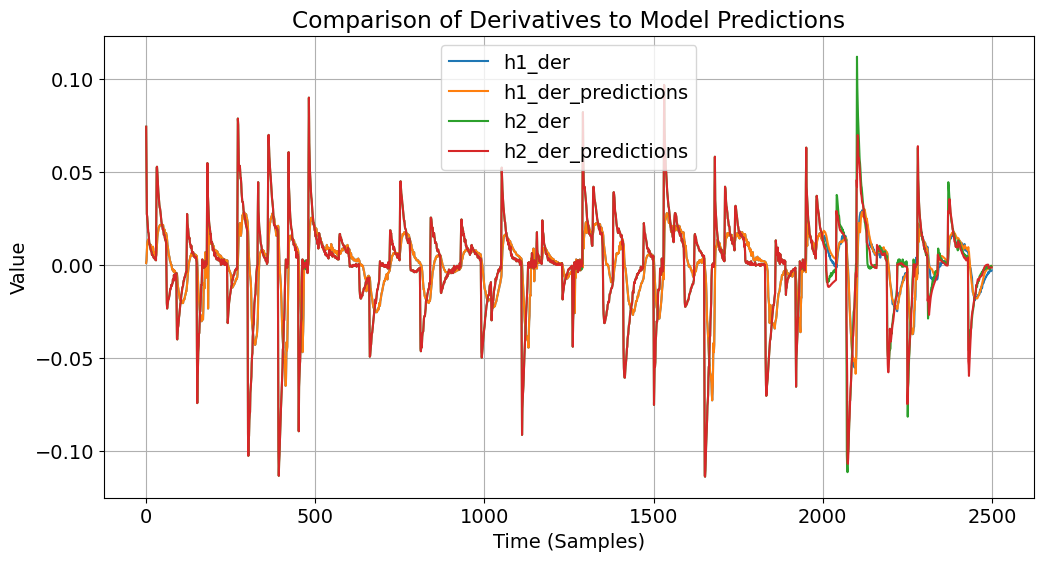

In [13]:
# Function to calculate weights based on distance to centroids
def calculate_weights(point, centroids):
    distances = np.linalg.norm(centroids - point, axis=1)**10
    weights = 1 / (distances + 1e-8)  # Add small epsilon to avoid division by zero
    return weights / np.sum(weights)

# Function to make a weighted prediction
def weighted_predict(point, gp_models, centroids):
    weights = calculate_weights(point, centroids)
    predictions = np.array([gp.predict([point])[0] for gp in gp_models])
    weighted_pred = np.sum(weights * predictions)
    return weighted_pred

# Function to find the closest centroid
def closest_centroid(point, centroids):
    distances = np.linalg.norm(centroids - point, axis=1)
    closest_index = np.argmin(distances)
    return closest_index

# Function to make a prediction using the closest GP model
def closest_predict(point, gp_models, centroids):
    closest_index = closest_centroid(point, centroids)
    closest_gp = gp_models[closest_index]
    prediction = closest_gp.predict([point])[0]
    return prediction

tank1['h1_der_predictions'] = tank1.apply(lambda row: closest_predict([row['u'], row['h1'], row['h2']], gp_models_dh1, centroids), axis = 1)
tank1['h2_der_predictions'] = tank1.apply(lambda row: closest_predict([row['u'], row['h1'], row['h2']], gp_models_dh2, centroids), axis = 1)

# Create Plot
tank1[['h1_der', 'h1_der_predictions', 'h2_der', 'h2_der_predictions']].plot(figsize=(12, 6))

plt.title('Comparison of Derivatives to Model Predictions')
plt.xlabel('Time (Samples)')
plt.ylabel('Value')
plt.legend(['h1_der', 'h1_der_predictions', 'h2_der', 'h2_der_predictions'])
plt.grid(True)

plt.show()

Now using the solve_ivp function to use a more complex method.

In [14]:
# Create a linear interpolation from our pump input signal for our function
u_t = interp1d(tank1['time'], tank1['u'])

# Create ODE function for the heights of the tanks
def dy_GP(t, y):
    """ODE to integrate GP of derivative."""
    return [closest_predict([u_t(t), y[0], y[1]], gp_models_dh1, centroids),
            closest_predict([u_t(t), y[0], y[1]], gp_models_dh2, centroids)]

# Integrate
solution = solve_ivp(fun = dy_GP, 
                     t_span = [tank1['time'].values[0], tank1['time'].values[-1]], # Time Range
                     y0 = [tank1["h1"].values[0], tank1["h2"].values[0]], # Initial Conditions
                     method = 'LSODA', 
                     t_eval = tank1['time'])
                     
tank1['h1_prediction_LSODA'] = solution.y[0]
tank1['h2_prediction_LSODA'] = solution.y[1]
tank1

,u,h1,h2,time,h1_der,h2_der,h1_der_predictions,h2_der_predictions,h1_prediction_LSODA,h2_prediction_LSODA
0,0.859640,0.380859,0.205078,0,0.000977,0.074219,0.000977,0.074219,0.380859,0.205078
1,0.859640,0.385742,0.576172,5,0.002441,0.051270,0.002441,0.051269,0.379253,0.478663
2,0.859640,0.405273,0.717773,10,0.006836,0.027344,0.006836,0.027344,0.400042,0.698780
3,0.859640,0.454102,0.849609,15,0.011230,0.025879,0.011230,0.025879,0.449951,0.839849
4,0.859640,0.517578,0.976562,20,0.012695,0.022949,0.012695,0.022949,0.508153,0.968492
...,...,...,...,...,...,...,...,...,...,...
2495,0.640136,1.933594,1.987305,12475,-0.003418,-0.001953,-0.001150,-0.001411,2.112231,2.027018
2496,0.640136,1.914062,1.977539,12480,-0.003418,-0.000977,-0.001024,-0.001385,2.100383,2.019268
2497,0.640136,1.899414,1.977539,12485,-0.002930,-0.000488,-0.000860,-0.001424,2.088563,2.011933
2498,0.640136,1.884766,1.972656,12490,-0.002930,-0.000977,-0.000726,-0.001434,2.076773,2.005011


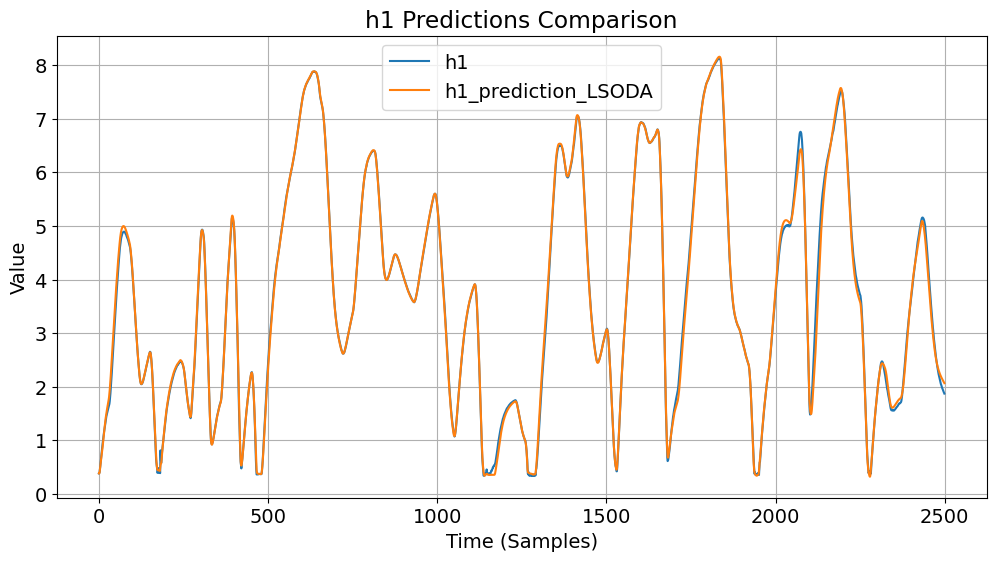

In [15]:
tank1[['h1', 'h1_prediction_LSODA']].plot(figsize=(12, 6))

plt.title('h1 Predictions Comparison')
plt.xlabel('Time (Samples)')
plt.ylabel('Value')
plt.legend(['h1', 'h1_prediction_LSODA', 'h1_prediction_Euler'])
plt.grid(True)

plt.show()

In [16]:
MSE = np.sum((tank1['h1'][2000:-1] - tank1['h1_prediction_LSODA'][2000:-1])**2)/len(tank1)
MSE

0.006122006221146599

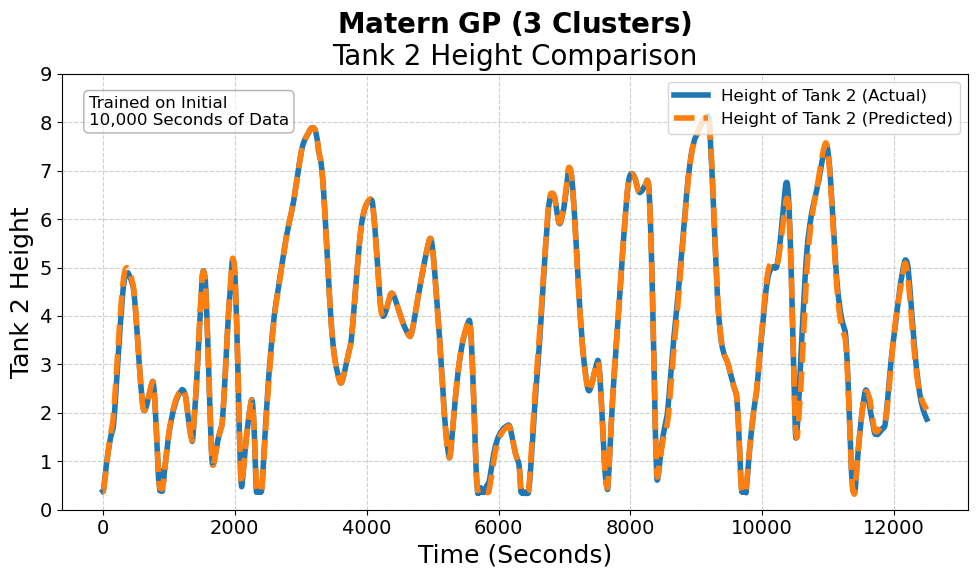

In [19]:
# Plot with improved aesthetics
plt.rcParams.update({'font.size': 14})  # Adjust the number to increase/decrease font size
fig, ax = plt.subplots(figsize=(10, 6))

# Plot both the actual and predicted data
ax.plot(tank1['time'], tank1['h1'], label='h1', linewidth=4, linestyle='-')#, color='blue')
ax.plot(tank1['time'], tank1['h1_prediction_LSODA'], label='h1_prediction', linewidth=4, linestyle='--')#, color='red')

# Enhancing the graph with titles, labels, and grid
ax.set_title(r'$\bf{Matern\ GP\ (3\ Clusters) }$' + '\nTank 2 Height Comparison', fontsize=20)
# ax.set_title('3 Clusters Matern GP Tank 1 Height Comparison', fontsize=20)
ax.set_xlabel('Time (Seconds)', fontsize=18)
ax.set_ylabel('Tank 2 Height', fontsize=18)
ax.legend(['Height of Tank 2 (Actual)', 'Height of Tank 2 (Predicted)'], fontsize=12, loc='upper right')

ax.grid(True, linestyle='--', alpha=0.6)

# ax.text(-250, 7, 'Trained on Initial \n10,000 Seconds of Data', fontsize=12, color='black', bbox = dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.4', alpha = 0.6))

# Add a note in the upper-left corner with a rounded box
ax.text(0.03, 0.95, 'Trained on Initial \n10,000 Seconds of Data',
        fontsize=12, color='black',
        bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.3', alpha = 0.6),
        transform=ax.transAxes,  # Use normalized coordinates
        verticalalignment='top',  # Align text to the top of the box
        horizontalalignment='left')  # Align text to the left

ax.set_ylim(0, 9)

# Show plot
plt.tight_layout()
plt.show()

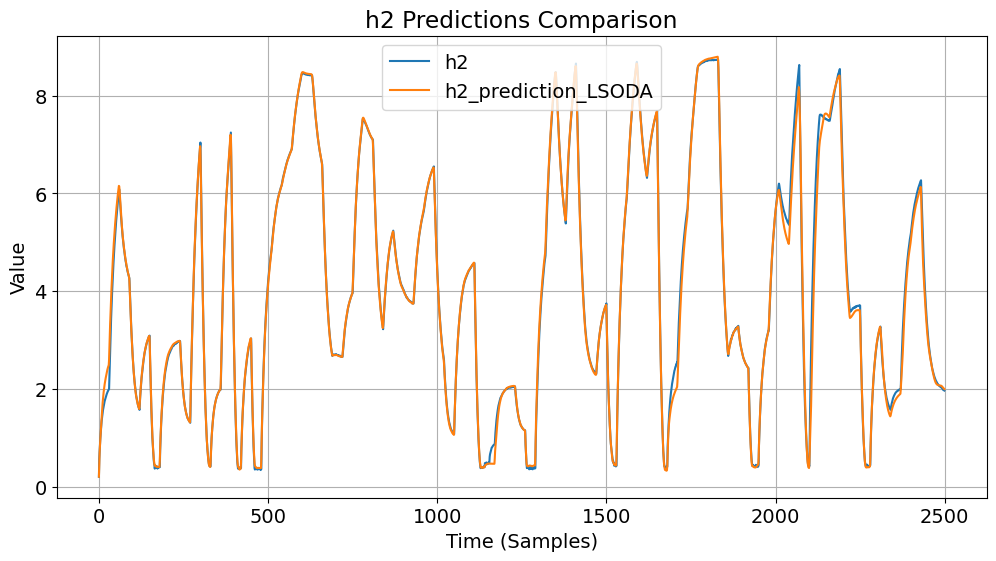

In [18]:
tank1[['h2', 'h2_prediction_LSODA']].plot(figsize=(12, 6))

plt.title('h2 Predictions Comparison')
plt.xlabel('Time (Samples)')
plt.ylabel('Value')
plt.legend(['h2', 'h2_prediction_LSODA', 'h2_prediction_Euler'])
plt.grid(True)

plt.show()